#### Task 2: Comparative Analysis of Google and Baidu
- Objective:
- Compare the response patterns of Google and Baidu in their autocomplete suggestions.
- Actions:Common Groups Analysis:
 - Identify common social or thematic groups in suggestions from both platforms. Count the number of these common groups.
- Chi-test for Negative Ratio:
 - Conduct a T-test for the negative ratio in English on Google and Chinese on Baidu.
- Distribution Analysis:
- Evaluate how suggestions are distributed among different social or thematic groups.

In [1]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import fisher_exact
from collections import defaultdict

# Load datasets
baidu_file_path = '../data/baidu.csv'  # Replace with your file path
google_file_path = '../data/google.csv'  # Replace with your file path

baidu_df = pd.read_csv(baidu_file_path)
google_df = pd.read_csv(google_file_path)
baidu_df = baidu_df[baidu_df['suggestion_starts_with_query']]
google_df = google_df[google_df['suggestion_starts_with_query']]

In [9]:


# Remove duplicates and rename column in Baidu dataset
baidu_df = baidu_df.drop_duplicates(subset=['group', 'completion']).rename(columns={'English': 'group_English'})

# Remove duplicates in Google dataset
google_df = google_df.drop_duplicates(subset=['group', 'completion'])

# Convert 'sentiment_rating_full_suggestion' to numeric type in both datasets
baidu_df['sentiment_rating_full_suggestion'] = pd.to_numeric(baidu_df['sentiment_rating_full_suggestion'], errors='coerce')
google_df['sentiment_rating_full_suggestion'] = pd.to_numeric(google_df['sentiment_rating_full_suggestion'], errors='coerce')

# Identify common groups
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))

# Filter datasets for common groups
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# Function to create a contingency table for each category
def create_contingency_table(df, category, sentiment_col):
    negative_reviews = df[df[sentiment_col] == 3.0]
    negative_count = negative_reviews['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    non_negative_count = total_count - negative_count
    return [negative_count, non_negative_count]

# Function to calculate the number of negative sentiments and total sentiments
def calculate_counts(df, category, sentiment_col):
    negative_count = df[df[sentiment_col] == 3.0]['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    return negative_count, total_count

# List of unique categories
unique_categories = set(baidu_common['category']).union(google_common['category'])

# Performing Fisher's Exact Test and Z-test for proportions for each category
fisher_exact_results = defaultdict(dict)
z_test_results = defaultdict(dict)
for category in unique_categories:
    # Fisher's Exact Test
    baidu_table = create_contingency_table(baidu_common, category, 'sentiment_rating_full_suggestion')
    google_table = create_contingency_table(google_common, category, 'sentiment_rating_full_suggestion')
    oddsratio, fisher_p_value = fisher_exact([baidu_table, google_table]) if sum(baidu_table) > 0 and sum(google_table) > 0 else (float('nan'), 1.0)
    fisher_exact_results[category]['Odds Ratio'] = oddsratio
    fisher_exact_results[category]['P-value'] = fisher_p_value

    # Z-test for Proportions
    baidu_neg, baidu_total = calculate_counts(baidu_common, category, 'sentiment_rating_full_suggestion')
    google_neg, google_total = calculate_counts(google_common, category, 'sentiment_rating_full_suggestion')
    z_stat, z_p_value = sm.stats.proportions_ztest([baidu_neg, google_neg], [baidu_total, google_total])
    z_test_results[category] = {'Z-Statistic': z_stat, 'P-value': z_p_value}

# Printing the results
print("Fisher's Exact Test Results:")
for category, results in fisher_exact_results.items():
    print(f"Category: {category}")
    print(f"  Odds Ratio: {results['Odds Ratio']}")
    print(f"  P-value: {results['P-value']}\n")

print("Z-test for Proportions Results:")
for category, results in z_test_results.items():
    print(f"Category: {category}")
    print(f"  Z-Statistic: {results['Z-Statistic']}")
    print(f"  P-value: {results['P-value']}\n")


Fisher's Exact Test Results:
Category: Political
  Odds Ratio: 4.0
  P-value: 0.2906346749226006

Category: Gender
  Odds Ratio: 0.9417721518987342
  P-value: 0.8884090048248503

Category: Age
  Odds Ratio: 2.984126984126984
  P-value: 0.20356337353173265

Category: Lifestyle
  Odds Ratio: 1.4285714285714286
  P-value: 0.7154599542936638

Category: Religion
  Odds Ratio: inf
  P-value: 0.18750000000000006

Category: Nationalities
  Odds Ratio: 3.081896551724138
  P-value: 0.00014250909075960258

Category: Peoples
  Odds Ratio: 7.4375
  P-value: 0.021253196781366925

Z-test for Proportions Results:
Category: Political
  Z-Statistic: 1.3747727084867523
  P-value: 0.16920192165920178

Category: Gender
  Z-Statistic: -0.21214174665275287
  P-value: 0.8319964517009364

Category: Age
  Z-Statistic: 1.5559244385254893
  P-value: 0.11972606133054763

Category: Lifestyle
  Z-Statistic: 0.44847586353009217
  P-value: 0.6538098016956134

Category: Religion
  Z-Statistic: 2.1499353995462798
  P-va

In [10]:
import pandas as pd
from scipy.stats import fisher_exact
from collections import defaultdict

# Load datasets
baidu_file_path = '../data/baidu/baidu_follow_query.csv'  # Replace with your file path
google_file_path = '../data/google/google_follow_query.csv'  # Replace with your file path

baidu_df = pd.read_csv(baidu_file_path)
google_df = pd.read_csv(google_file_path)

# Remove duplicates and rename column in Baidu dataset
baidu_df = baidu_df.drop_duplicates(subset=['group', 'completion']).rename(columns={'English': 'group_English'})

# Remove duplicates in Google dataset
google_df = google_df.drop_duplicates(subset=['group', 'completion'])

# Function to assign common sentiment rating
def assign_common_sentiment_rating(df, rating_col, new_col):
    common_ratings = df.groupby('extracted_suggestion')[rating_col].agg(lambda x: pd.Series.mode(x)[0])
    df[new_col] = df['extracted_suggestion'].map(common_ratings)
    df[new_col] = pd.to_numeric(df[new_col], errors='coerce')
    return df

# Apply function to datasets
baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_completion', 'common_sentiment_rating')
baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_full_suggestion', 'common_sentiment_rating_full')

google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_completion', 'common_sentiment_rating')
google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_full_suggestion', 'common_sentiment_rating_full')

# Identify common groups
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))

# Filter datasets for common groups
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# Function to create a contingency table for each category
def create_contingency_table(df, category, sentiment_col):
    negative_reviews = df[df[sentiment_col] == 3.0]
    negative_count = negative_reviews['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    non_negative_count = total_count - negative_count
    return [negative_count, non_negative_count]

# List of unique categories
unique_categories = set(baidu_common['category']).union(google_common['category'])

# Performing Fisher's Exact Test for each category
fisher_exact_results = defaultdict(dict)
for category in unique_categories:
    baidu_table = create_contingency_table(baidu_common, category, 'common_sentiment_rating')
    google_table = create_contingency_table(google_common, category, 'common_sentiment_rating')
    # Fisher's Exact Test
    oddsratio, p_value = fisher_exact([baidu_table, google_table])
    fisher_exact_results[category]['Odds Ratio'] = oddsratio
    fisher_exact_results[category]['P-value'] = p_value

# Print results
for category, results in fisher_exact_results.items():
    print(f"Category: {category}")
    for key, value in results.items():
        print(f"  {key}: {value}")
    print()


Category: Political
  Odds Ratio: 1.375
  P-value: 1.0

Category: Gender
  Odds Ratio: 1.0056584362139918
  P-value: 1.0

Category: Age
  Odds Ratio: 2.7564102564102564
  P-value: 0.14937546802699433

Category: Lifestyle
  Odds Ratio: 0.57
  P-value: 0.7007759983586972

Category: Religion
  Odds Ratio: inf
  P-value: 1.0

Category: Nationalities
  Odds Ratio: 2.3386243386243386
  P-value: 0.005646081610075097

Category: Peoples
  Odds Ratio: inf
  P-value: 0.0007970131314101389


In [11]:
# Re-importing the required packages
import pandas as pd
import statsmodels.api as sm
from scipy.stats import fisher_exact
from collections import defaultdict


# Load datasets
baidu_file_path = '../data/baidu/baidu_follow_query.csv'  # Replace with your file path
google_file_path = '../data/google/google_follow_query.csv'  # Replace with your file path

baidu_df = pd.read_csv(baidu_file_path)
google_df = pd.read_csv(google_file_path)

# Preprocessing steps as provided
baidu_df = baidu_df.drop_duplicates(subset=['group', 'completion']).rename(columns={'English': 'group_English'})
google_df = google_df.drop_duplicates(subset=['group', 'completion'])

# Assign common sentiment rating
def assign_common_sentiment_rating(df, rating_col, new_col):
    common_ratings = df.groupby('extracted_suggestion')[rating_col].agg(lambda x: pd.Series.mode(x)[0])
    df[new_col] = df['extracted_suggestion'].map(common_ratings)
    df[new_col] = pd.to_numeric(df[new_col], errors='coerce')
    return df

baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_completion', 'common_sentiment_rating')
google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_completion', 'common_sentiment_rating')

# Identify common groups
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))

# Filter datasets for common groups
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# Function to create a contingency table for each category
def create_contingency_table(df, category, sentiment_col):
    negative_reviews = df[df[sentiment_col] == 3.0]
    negative_count = negative_reviews['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    non_negative_count = total_count - negative_count
    return [negative_count, non_negative_count]

# Function to calculate the number of negative sentiments and total sentiments
def calculate_counts(df, category, sentiment_col):
    negative_count = df[df[sentiment_col] == 3.0]['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    return negative_count, total_count

# List of unique categories
unique_categories = set(baidu_common['category']).union(google_common['category'])

# Performing Fisher's Exact Test and Z-test for proportions for each category
fisher_exact_results = defaultdict(dict)
z_test_results = defaultdict(dict)
for category in unique_categories:
    baidu_table = create_contingency_table(baidu_common, category, 'common_sentiment_rating')
    google_table = create_contingency_table(google_common, category, 'common_sentiment_rating')
    oddsratio, fisher_p_value = fisher_exact([baidu_table, google_table]) if sum(baidu_table) > 0 and sum(google_table) > 0 else (float('nan'), 1.0)
    fisher_exact_results[category]['Odds Ratio'] = oddsratio
    fisher_exact_results[category]['P-value'] = fisher_p_value

    baidu_neg, baidu_total = calculate_counts(baidu_common, category, 'common_sentiment_rating')
    google_neg, google_total = calculate_counts(google_common, category, 'common_sentiment_rating')
    z_stat, z_p_value = sm.stats.proportions_ztest([baidu_neg, google_neg], [baidu_total, google_total])
    z_test_results[category] = {'Z-Statistic': z_stat, 'P-value': z_p_value}

# Prepare results for display
fisher_exact_result_list = [(category, results['Odds Ratio'], results['P-value']) 
                           for category, results in fisher_exact_results.items()]
z_test_result_list = [(category, results['Z-Statistic'], results['P-value']) 
                      for category, results in z_test_results.items()]

print(fisher_exact_result_list)
print(z_test_result_list) # Display first 5 results for brevity



[('Political', 1.375, 1.0), ('Gender', 1.0056584362139918, 1.0), ('Age', 2.7564102564102564, 0.14937546802699433), ('Lifestyle', 0.57, 0.7007759983586972), ('Religion', inf, 1.0), ('Nationalities', 2.3386243386243386, 0.005646081610075097), ('Peoples', inf, 0.0007970131314101389)]
[('Political', 0.3055050463303893, 0.759981527157728), ('Gender', 0.02124861381462633, 0.9830473348066422), ('Age', 1.521364646379845, 0.128168355625697), ('Lifestyle', -0.7103469967668489, 0.4774889828560639), ('Religion', 1.0327955589886446, 0.30169958247834794), ('Nationalities', 2.7814356456836054, 0.005411905930311652), ('Peoples', 3.3145447495171525, 0.0009179248601096595)]


In [12]:
import pandas as pd
from scipy.stats import chi2_contingency
from collections import defaultdict

# Load datasets
baidu_file_path = '../data/baidu/baidu_follow_query.csv'  # Replace with your file path
google_file_path = '../data/google/google_follow_query.csv'  # Replace with your file path

baidu_df = pd.read_csv(baidu_file_path)
google_df = pd.read_csv(google_file_path)

# Remove duplicates and rename column in Baidu dataset
baidu_df = baidu_df.drop_duplicates(subset=['group', 'completion']).rename(columns={'English': 'group_English'})

# Remove duplicates in Google dataset
google_df = google_df.drop_duplicates(subset=['group', 'completion'])

# Function to assign common sentiment rating
def assign_common_sentiment_rating(df, rating_col, new_col):
    common_ratings = df.groupby('extracted_suggestion')[rating_col].agg(lambda x: pd.Series.mode(x)[0])
    df[new_col] = df['extracted_suggestion'].map(common_ratings)
    df[new_col] = pd.to_numeric(df[new_col], errors='coerce')
    return df

# Apply function to datasets
baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_completion', 'common_sentiment_rating')
baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_full_suggestion', 'common_sentiment_rating_full')

google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_completion', 'common_sentiment_rating')
google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_full_suggestion', 'common_sentiment_rating_full')

# Identify common groups
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))

# Filter datasets for common groups
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# Function to create a contingency table for each category with rates
def create_contingency_table(df, category, sentiment_col):
    negative_reviews = df[df[sentiment_col] == 3.0]
    negative_count = negative_reviews['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    if total_count > 0:
        negative_rate = negative_count / total_count
        non_negative_rate = 1 - negative_rate
        return [negative_rate, non_negative_rate]
    return [0, 0]  # Handle division by zero if total_count is 0

# List of unique categories
unique_categories = set(baidu_common['category']).union(google_common['category'])

# Dictionary to hold chi-square test results for each category
chi_square_results = defaultdict(dict)

# Perform Chi-Square test for each category
for category in unique_categories:
    contingency_table = []
    contingency_table.append(create_contingency_table(baidu_common, category, 'common_sentiment_rating'))
    contingency_table.append(create_contingency_table(google_common, category, 'common_sentiment_rating'))

    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[category]['Chi-Square Statistic'] = chi2
    chi_square_results[category]['P-value'] = p
    chi_square_results[category]['Degrees of Freedom'] = dof

# Print results
for category, results in chi_square_results.items():
    print(f"Category: {category}")
    for key, value in results.items():
        print(f"  {key}: {value}")
    print()


Category: Political
  Chi-Square Statistic: 0.0
  P-value: 1.0
  Degrees of Freedom: 1

Category: Gender
  Chi-Square Statistic: 0.0
  P-value: 1.0
  Degrees of Freedom: 1

Category: Age
  Chi-Square Statistic: 0.0
  P-value: 1.0
  Degrees of Freedom: 1

Category: Lifestyle
  Chi-Square Statistic: 0.0
  P-value: 1.0
  Degrees of Freedom: 1

Category: Religion
  Chi-Square Statistic: 0.0
  P-value: 1.0
  Degrees of Freedom: 1

Category: Nationalities
  Chi-Square Statistic: 0.0
  P-value: 1.0
  Degrees of Freedom: 1

Category: Peoples
  Chi-Square Statistic: 0.0
  P-value: 1.0
  Degrees of Freedom: 1


In [13]:
import pandas as pd
from scipy.stats import chi2_contingency
from collections import defaultdict

# Load datasets
baidu_file_path = '../data/baidu/baidu_follow_query.csv'  # Replace with your file path
google_file_path = '../data/google/google_follow_query.csv'  # Replace with your file path

baidu_df = pd.read_csv(baidu_file_path)
google_df = pd.read_csv(google_file_path)

# Remove duplicates and rename column in Baidu dataset
baidu_df = baidu_df.drop_duplicates(subset=['group', 'completion']).rename(columns={'English': 'group_English'})

# Remove duplicates in Google dataset
google_df = google_df.drop_duplicates(subset=['group', 'completion'])

# Function to assign common sentiment rating
def assign_common_sentiment_rating(df, rating_col, new_col):
    common_ratings = df.groupby('extracted_suggestion')[rating_col].agg(lambda x: pd.Series.mode(x)[0])
    df[new_col] = df['extracted_suggestion'].map(common_ratings)
    df[new_col] = pd.to_numeric(df[new_col], errors='coerce')
    return df

# Apply function to datasets
baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_completion', 'common_sentiment_rating')
baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_full_suggestion', 'common_sentiment_rating_full')

google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_completion', 'common_sentiment_rating')
google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_full_suggestion', 'common_sentiment_rating_full')

# Identify common groups
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))

# Filter datasets for common groups
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# Function to create a contingency table for each category
def create_contingency_table(df, category, sentiment_col):
    negative_reviews = df[df[sentiment_col] == 3.0]
    negative_count = negative_reviews['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    non_negative_count = total_count - negative_count
    return [negative_count, non_negative_count]

# List of unique categories
unique_categories = set(baidu_common['category']).union(google_common['category'])

# Dictionary to hold chi-square test results for each category
chi_square_results = defaultdict(dict)

# Perform Chi-Square test for each category
for category in unique_categories:
    contingency_table = []
    contingency_table.append(create_contingency_table(baidu_common, category, 'common_sentiment_rating'))
    contingency_table.append(create_contingency_table(google_common, category, 'common_sentiment_rating'))

    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[category]['Chi-Square Statistic'] = chi2
    chi_square_results[category]['P-value'] = p
    chi_square_results[category]['Degrees of Freedom'] = dof

# Print results
for category, results in chi_square_results.items():
    print(f"Category: {category}")
    for key, value in results.items():
        print(f"  {key}: {value}")
    print()

Category: Political
  Chi-Square Statistic: 0.0
  P-value: 1.0
  Degrees of Freedom: 1

Category: Gender
  Chi-Square Statistic: 0.0
  P-value: 1.0
  Degrees of Freedom: 1

Category: Age
  Chi-Square Statistic: 1.3210103034720384
  P-value: 0.2504108132826184
  Degrees of Freedom: 1

Category: Lifestyle
  Chi-Square Statistic: 0.10377038043478275
  P-value: 0.7473511035505673
  Degrees of Freedom: 1

Category: Religion
  Chi-Square Statistic: 0.0
  P-value: 1.0
  Degrees of Freedom: 1

Category: Nationalities
  Chi-Square Statistic: 6.943649029523728
  P-value: 0.008411734106163072
  Degrees of Freedom: 1

Category: Peoples
  Chi-Square Statistic: 8.716666028097064
  P-value: 0.0031531413560750886
  Degrees of Freedom: 1


In [14]:
import pandas as pd
from scipy.stats import chi2_contingency
from collections import defaultdict


# Load datasets
baidu_file_path = '../data/baidu/baidu_follow_query.csv'  # Replace with your file path
google_file_path = '../data/google/google_follow_query.csv'  # Replace with your file path

baidu_df = pd.read_csv(baidu_file_path)
google_df = pd.read_csv(google_file_path)

# Remove duplicates and rename column in Baidu dataset
baidu_df = baidu_df.drop_duplicates(subset=['group', 'completion']).rename(columns={'English': 'group_English'})

# Remove duplicates in Google dataset
google_df = google_df.drop_duplicates(subset=['group', 'completion'])

# Convert 'sentiment_rating_full_suggestion' to numeric type in both datasets
baidu_df['sentiment_rating_full_suggestion'] = pd.to_numeric(baidu_df['sentiment_rating_full_suggestion'], errors='coerce')
google_df['sentiment_rating_full_suggestion'] = pd.to_numeric(google_df['sentiment_rating_full_suggestion'], errors='coerce')

# Identify common groups
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))

# Filter datasets for common groups
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# Function to create a contingency table for each category
def create_contingency_table(df, category, sentiment_col):
    negative_reviews = df[df[sentiment_col] == 3.0]
    negative_count = negative_reviews['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    non_negative_count = total_count - negative_count
    return [negative_count, non_negative_count]

# List of unique categories
unique_categories = set(baidu_common['category']).union(google_common['category'])

# Dictionary to hold chi-square test results for each category
chi_square_results = defaultdict(dict)

# Perform Chi-Square test for each category using 'sentiment_rating_full_suggestion'
for category in unique_categories:
    contingency_table = []
    contingency_table.append(create_contingency_table(baidu_common, category, 'sentiment_rating_full_suggestion'))
    contingency_table.append(create_contingency_table(google_common, category, 'sentiment_rating_full_suggestion'))

    # Skip categories with zero counts to avoid ValueError
    if any(cell == 0 for row in contingency_table for cell in row):
        continue

    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[category]['Chi-Square Statistic'] = chi2
    chi_square_results[category]['P-value'] = p
    chi_square_results[category]['Degrees of Freedom'] = dof

# Print results
for category, results in chi_square_results.items():
    print(f"Category: {category}")
    for key, value in results.items():
        print(f"  {key}: {value}")
    print()


Category: Political
  Chi-Square Statistic: 0.7058333333333335
  P-value: 0.4008305242189134
  Degrees of Freedom: 1

Category: Gender
  Chi-Square Statistic: 0.005073190830128636
  P-value: 0.9432176221588979
  Degrees of Freedom: 1

Category: Age
  Chi-Square Statistic: 1.297176781551781
  P-value: 0.25472956157113996
  Degrees of Freedom: 1

Category: Lifestyle
  Chi-Square Statistic: 0.003379766600920418
  P-value: 0.9536404901193997
  Degrees of Freedom: 1

Category: Nationalities
  Chi-Square Statistic: 13.586123407650351
  P-value: 0.00022786370926907015
  Degrees of Freedom: 1

Category: Peoples
  Chi-Square Statistic: 4.932857622114868
  P-value: 0.026350707941913735
  Degrees of Freedom: 1


In [15]:
import pandas as pd
from scipy.stats import chi2_contingency
from collections import defaultdict

# Function to load and clean data
def load_and_clean_data(file_path, drop_duplicates_cols, rename_cols=None):
    df = pd.read_csv(file_path)
    df = df.drop_duplicates(subset=drop_duplicates_cols)
    if rename_cols:
        df = df.rename(columns=rename_cols)
    return df

# Function to assign common sentiment rating
def assign_common_sentiment_rating(df, rating_cols):
    for rating_col, new_col in rating_cols:
        common_ratings = df.groupby('extracted_suggestion')[rating_col].agg(lambda x: pd.Series.mode(x)[0])
        df[new_col] = df['extracted_suggestion'].map(common_ratings)
        df[new_col] = pd.to_numeric(df[new_col], errors='coerce')
    return df

# Function to create a contingency table for each category
def create_contingency_table(df, category, sentiment_col):
    negative_reviews = df[df[sentiment_col] == 3.0]
    negative_count = negative_reviews['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    return [negative_count, total_count - negative_count]

# Load and clean datasets
baidu_df = load_and_clean_data('../data/baidu/baidu_follow_query.csv', 
                               ['group', 'completion'], 
                               {'English': 'group_English'})
google_df = load_and_clean_data('../data/google/google_follow_query.csv', 
                                ['group', 'completion'])

# Assign common sentiment rating
rating_cols = [('sentiment_rating_completion', 'common_sentiment_rating'),
               ('sentiment_rating_full_suggestion', 'common_sentiment_rating_full')]
baidu_df = assign_common_sentiment_rating(baidu_df, rating_cols)
google_df = assign_common_sentiment_rating(google_df, rating_cols)

# Identify common groups and filter datasets
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# Perform Chi-Square test for each category
chi_square_results = defaultdict(dict)
unique_categories = set(baidu_common['category']).union(google_common['category'])
for category in unique_categories:
    baidu_table = create_contingency_table(baidu_common, category, 'common_sentiment_rating_full')
    google_table = create_contingency_table(google_common, category, 'common_sentiment_rating_full')
    if any(cell == 0 for row in [baidu_table, google_table] for cell in row):
        continue
    chi2, p, dof, _ = chi2_contingency([baidu_table, google_table])
    chi_square_results[category] = {'Chi-Square Statistic': chi2, 'P-value': p, 'Degrees of Freedom': dof}

# Print results
for category, results in chi_square_results.items():
    print(f"Category: {category}")
    for key, value in results.items():
        print(f"  {key}: {value}")
    print()


Category: Political
  Chi-Square Statistic: 1.4765625
  P-value: 0.22431312651115032
  Degrees of Freedom: 1

Category: Gender
  Chi-Square Statistic: 0.04845921089762764
  P-value: 0.8257663839877611
  Degrees of Freedom: 1

Category: Age
  Chi-Square Statistic: 0.2076858274301458
  P-value: 0.6485873068159544
  Degrees of Freedom: 1

Category: Lifestyle
  Chi-Square Statistic: 0.20265835298162885
  P-value: 0.6525836025684935
  Degrees of Freedom: 1

Category: Nationalities
  Chi-Square Statistic: 13.194300460026026
  P-value: 0.0002808017961599203
  Degrees of Freedom: 1

Category: Peoples
  Chi-Square Statistic: 10.55826441102757
  P-value: 0.001156697525814918
  Degrees of Freedom: 1


In [16]:


# Function to assign common sentiment rating
def assign_common_sentiment_rating(df, rating_col, new_col):
    common_ratings = df.groupby('extracted_suggestion')[rating_col].agg(lambda x: pd.Series.mode(x)[0])
    df[new_col] = df['extracted_suggestion'].map(common_ratings)
    df[new_col] = pd.to_numeric(df[new_col], errors='coerce')
    return df

# Apply function to datasets
baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_completion', 'common_sentiment_rating')
baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_full_suggestion', 'common_sentiment_rating_full')

google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_completion', 'common_sentiment_rating')
google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_full_suggestion', 'common_sentiment_rating_full')

# Identify common groups
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))

# Filter datasets for common groups
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# Function to create a contingency table for each category
def create_contingency_table(df, category, sentiment_col):
    negative_reviews = df[df[sentiment_col] == 3.0]
    negative_count = negative_reviews['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    non_negative_count = total_count - negative_count
    return [negative_count, non_negative_count]

# List of unique categories
unique_categories = set(baidu_common['category']).union(google_common['category'])

# Dictionary to hold chi-square test results for each category
chi_square_results = defaultdict(dict)

# Perform Chi-Square test for each category using 'sentiment_rating_full_suggestion'
for category in unique_categories:
    contingency_table = []
    contingency_table.append(create_contingency_table(baidu_common, category, 'sentiment_rating_full_suggestion'))
    contingency_table.append(create_contingency_table(google_common, category, 'sentiment_rating_full_suggestion'))

    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[category]['Chi-Square Statistic'] = chi2
    chi_square_results[category]['P-value'] = p
    chi_square_results[category]['Degrees of Freedom'] = dof

# Print results
for category, results in chi_square_results.items():
    print(f"Category: {category}")
    for key, value in results.items():
        print(f"  {key}: {value}")
    print()


ValueError: The internally computed table of expected frequencies has a zero element at (0, 0).

In [17]:
import pandas as pd
from scipy.stats import chi2_contingency
from collections import defaultdict

# Load datasets
baidu_file_path = '/path/to/baidu_follow_query.csv'  # Replace with your file path
google_file_path = '/path/to/google_follow_query.csv'  # Replace with your file path

baidu_df = pd.read_csv(baidu_file_path)
google_df = pd.read_csv(google_file_path)

# Remove duplicates and rename column in Baidu dataset
baidu_df = baidu_df.drop_duplicates(subset=['group', 'completion']).rename(columns={'English': 'group_English'})

# Remove duplicates in Google dataset
google_df = google_df.drop_duplicates(subset=['group', 'completion'])

# Function to assign common sentiment rating
def assign_common_sentiment_rating(df, rating_col, new_col):
    common_ratings = df.groupby('extracted_suggestion')[rating_col].agg(lambda x: pd.Series.mode(x)[0])
    df[new_col] = df['extracted_suggestion'].map(common_ratings)
    df[new_col] = pd.to_numeric(df[new_col], errors='coerce')
    return df

# Apply function to datasets
baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_completion', 'common_sentiment_rating')
baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_full_suggestion', 'common_sentiment_rating_full')

google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_completion', 'common_sentiment_rating')
google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_full_suggestion', 'common_sentiment_rating_full')

# Identify common groups
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))

# Filter datasets for common groups
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# Function to create a contingency table for each category
def create_contingency_table(df, category, sentiment_col):
    negative_reviews = df[df[sentiment_col] == 3.0]
    negative_count = negative_reviews['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    non_negative_count = total_count - negative_count
    return [negative_count, non_negative_count]

# List of unique categories
unique_categories = set(baidu_common['category']).union(google_common['category'])

# Dictionary to hold chi-square test results for each category
chi_square_results = defaultdict(dict)

# Perform Chi-Square test for each category using 'sentiment_rating_full_suggestion'
for category in unique_categories:
    contingency_table = []
    contingency_table.append(create_contingency_table(baidu_common, category, 'sentiment_rating_full_suggestion'))
    contingency_table.append(create_contingency_table(google_common, category, 'sentiment_rating_full_suggestion'))

    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[category]['Chi-Square Statistic'] = chi2
    chi_square_results[category]['P-value'] = p
    chi_square_results[category]['Degrees of Freedom'] = dof

# Print results
for category, results in chi_square_results.items():
    print(f"Category: {category}")
    for key, value in results.items():
        print(f"  {key}: {value}")
    print()


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/baidu_follow_query.csv'

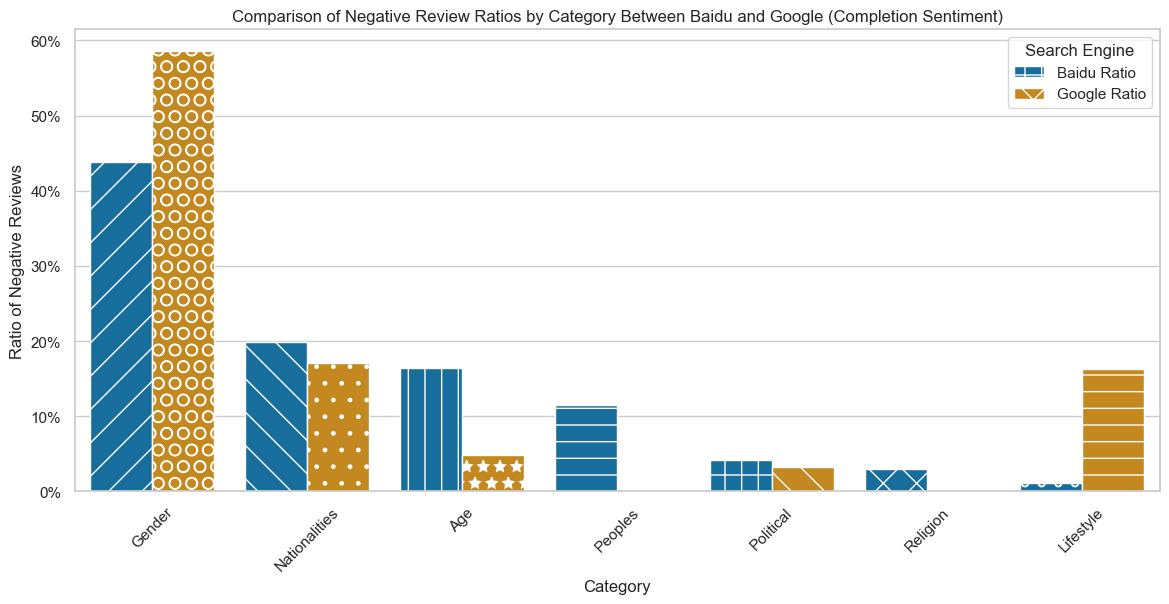

Chi-Square Statistic: 62.827888814017534, P-value: 1.1965868210505788e-11, Degrees of Freedom: 6


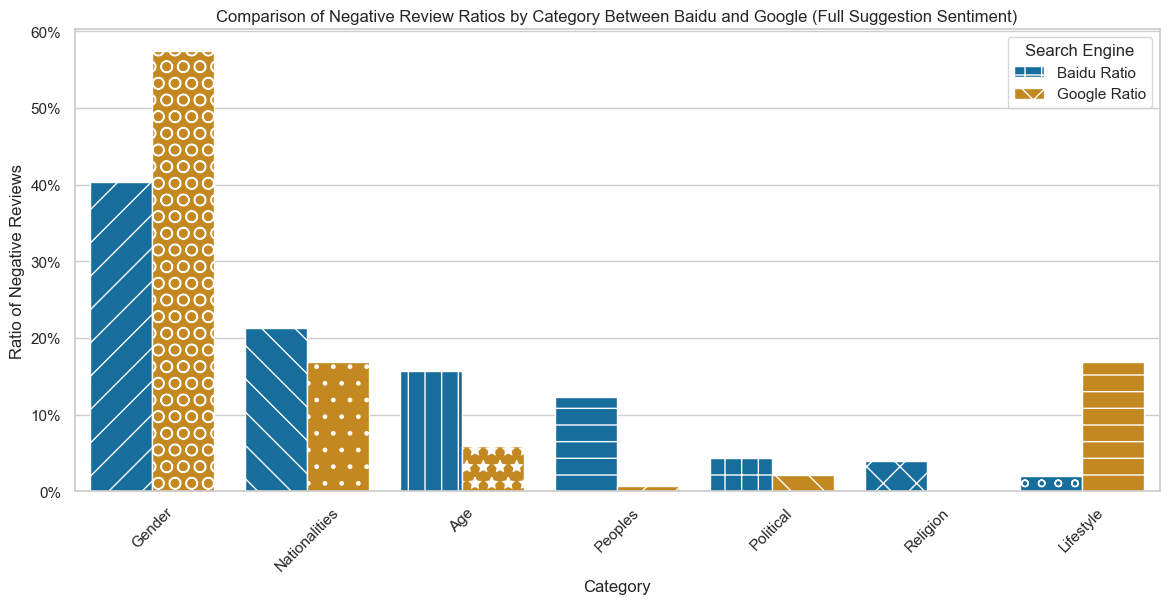

Chi-Square Statistic: 66.27798241218358, P-value: 2.3646280105933473e-12, Degrees of Freedom: 6


In [18]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Load data
baidu = pd.read_csv('../data/baidu/baidu_follow_query.csv')
google = pd.read_csv('../data/google/google_follow_query.csv')

# Preprocess and rename columns
baidu = baidu.drop_duplicates(subset=['group', 'completion']).rename(columns={'English': 'group_English'})
google = google.drop_duplicates(subset=['group', 'completion'])

# Function to assign common sentiment rating
def assign_common_sentiment_rating(df, rating_col, new_col):
    common_ratings = df.groupby('extracted_suggestion')[rating_col].agg(lambda x: pd.Series.mode(x)[0])
    df[new_col] = df['extracted_suggestion'].map(common_ratings)
    df[new_col] = pd.to_numeric(df[new_col], errors='coerce')
    return df

# Apply the function to Baidu and Google datasets for both types of sentiment ratings
baidu = assign_common_sentiment_rating(baidu, 'sentiment_rating_completion', 'common_sentiment_rating')
google = assign_common_sentiment_rating(google, 'sentiment_rating_completion', 'common_sentiment_rating')

baidu = assign_common_sentiment_rating(baidu, 'sentiment_rating_full_suggestion', 'common_sentiment_rating_full')
google = assign_common_sentiment_rating(google, 'sentiment_rating_full_suggestion', 'common_sentiment_rating_full')

# Identify common groups and filter for negative reviews
common_groups = set(baidu['group_English']).intersection(set(google['group']))

import matplotlib.ticker as mtick



# Analysis function with enhanced plotting
def perform_analysis(baidu, google, sentiment_col, title_suffix):
    baidu_common = baidu[baidu['group_English'].isin(common_groups) & (baidu[sentiment_col] == 3.0)]
    google_common = google[google['group'].isin(common_groups) & (google[sentiment_col] == 3.0)]

    # Calculate the ratio of negative reviews in each category
    category_ratio_baidu = baidu_common['category'].value_counts(normalize=True).reset_index()
    category_ratio_google = google_common['category'].value_counts(normalize=True).reset_index()

    # Merge and plot the ratio dataframes
    category_ratio_baidu.columns = ['Category', 'Baidu Ratio']
    category_ratio_google.columns = ['Category', 'Google Ratio']
    merged_ratios = category_ratio_baidu.merge(category_ratio_google, on='Category', how='outer').fillna(0)
    melted_ratios = pd.melt(merged_ratios, id_vars='Category', var_name='Dataset', value_name='Ratio')

    # Seaborn settings for a colorblind-friendly plot
    sns.set(style="whitegrid", palette="colorblind")

    # Plotting using seaborn
    plt.figure(figsize=(14, 6))
    sns_plot = sns.barplot(x='Category', y='Ratio', hue='Dataset', data=melted_ratios)

    # Adding hatch patterns for better distinction
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
    for bar, hatch in zip(sns_plot.patches, hatches * len(melted_ratios['Dataset'].unique())):
        bar.set_hatch(hatch)

    # Formatting y-axis labels as percentages
    sns_plot.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    plt.title(f'Comparison of Negative Review Ratios by Category Between Baidu and Google ({title_suffix})')
    plt.xticks(rotation=45)
    plt.xlabel('Category')
    plt.ylabel('Ratio of Negative Reviews')
    plt.legend(title='Search Engine')
    plt.show()

    # Chi-square test
    contingency_table_counts = pd.DataFrame({
        'Baidu': category_ratio_baidu.set_index('Category')['Baidu Ratio'] * len(baidu_common),
        'Google': category_ratio_google.set_index('Category')['Google Ratio'] * len(google_common)
    }).fillna(0)
    chi2, p, dof, expected = chi2_contingency(contingency_table_counts)
    print(f'Chi-Square Statistic: {chi2}, P-value: {p}, Degrees of Freedom: {dof}')

# Perform analysis for both types of sentiment ratings
perform_analysis(baidu, google, 'common_sentiment_rating', 'Completion Sentiment')
perform_analysis(baidu, google, 'common_sentiment_rating_full', 'Full Suggestion Sentiment')



In [ ]:
baidu_common = baidu[baidu['group_English'].isin(common_groups) ]
google_common = google[google['group'].isin(common_groups)]

In [ ]:
google_common.value_counts('category')

In [ ]:
baidu_common.value_counts('category')

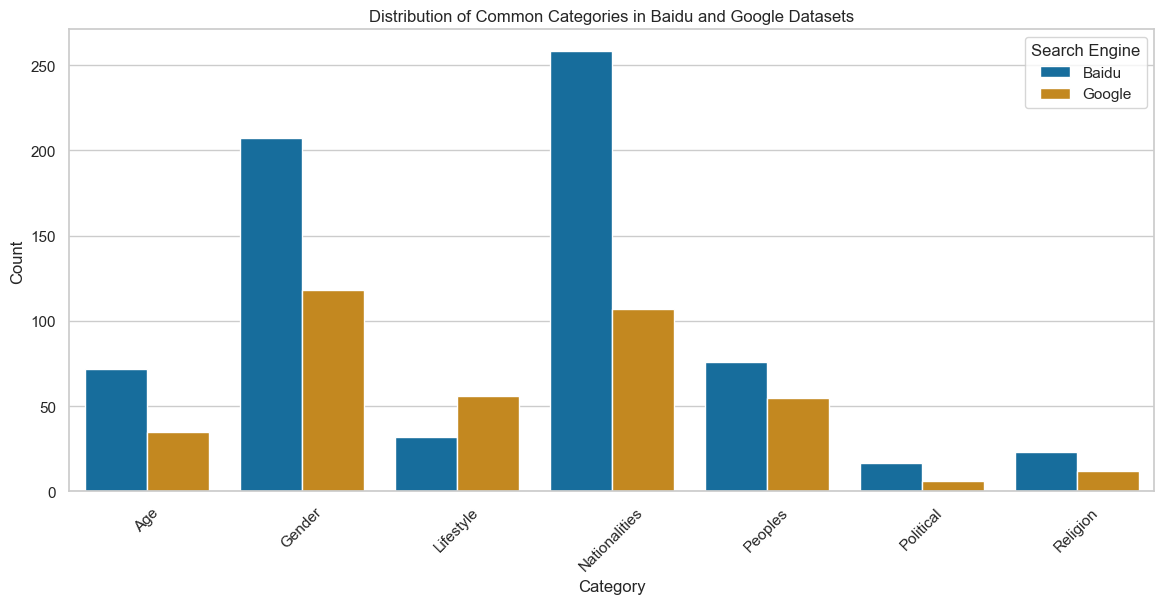

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'baidu' and 'google' are already loaded and preprocessed as per your previous code

# Identify common categories
common_categories = set(baidu['category']).intersection(set(google['category']))

# Filter datasets for common categories only
baidu_common = baidu[baidu['category'].isin(common_categories)]
google_common = google[google['category'].isin(common_categories)]

# Add a 'Source' column to each dataset to differentiate between Baidu and Google
baidu_common['Source'] = 'Baidu'
google_common['Source'] = 'Google'

# Combine the datasets
combined_data = pd.concat([baidu_common, google_common])

# Seaborn settings for a colorblind-friendly plot
sns.set(style="whitegrid", palette="colorblind")

# Plotting the distribution of common categories
plt.figure(figsize=(14, 6))
sns.countplot(data=combined_data, x='category', hue='Source')
plt.title('Distribution of Common Categories in Baidu and Google Datasets')
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Search Engine')
plt.show()


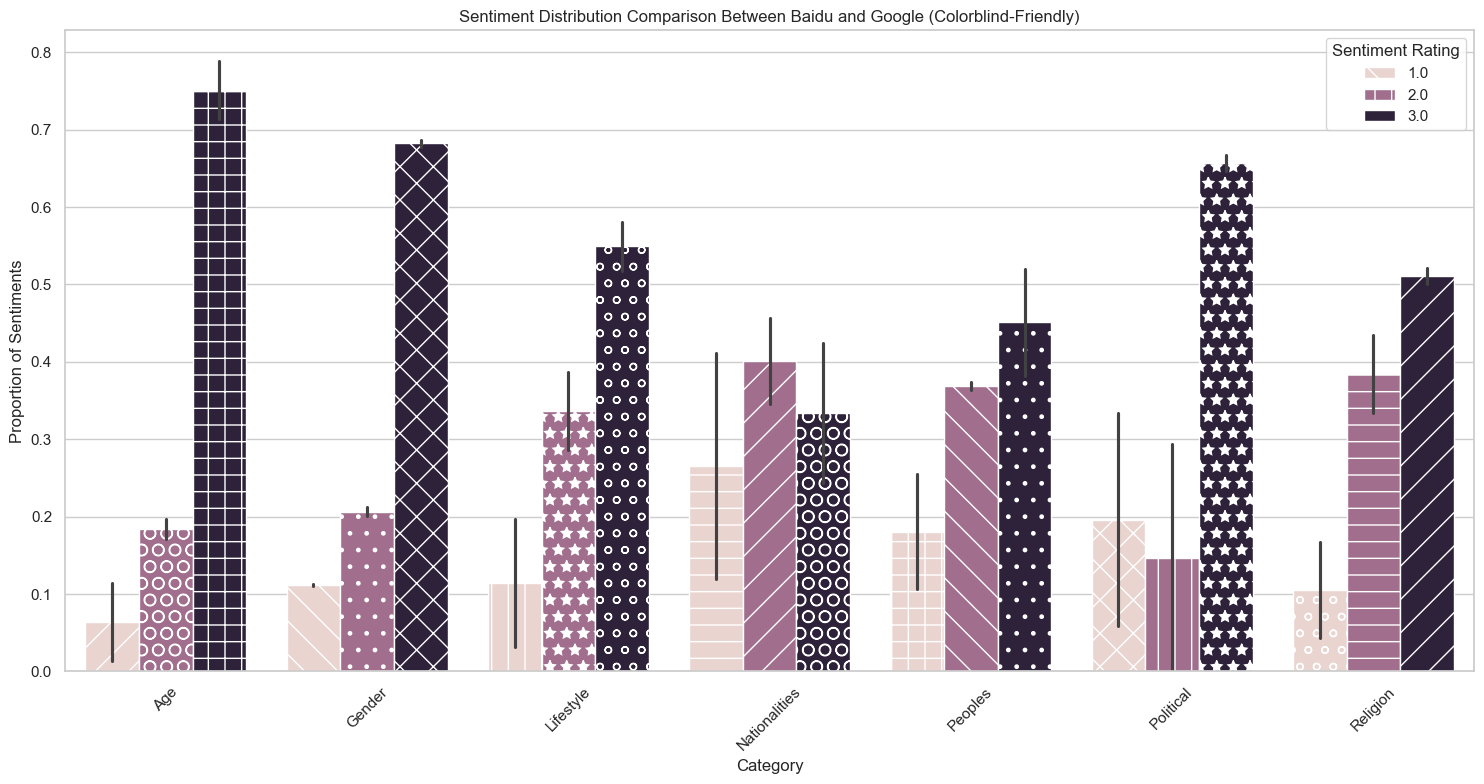

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
# Assuming 'baidu' and 'google' DataFrames are already loaded and preprocessed

# Function to analyze sentiment distribution and return proportions
def get_sentiment_distribution(df, category_col, sentiment_col):
    # Group by category and sentiment rating
    sentiment_distribution = df.groupby([category_col, sentiment_col]).size().unstack(fill_value=0)

    # Calculate proportions
    sentiment_proportions = sentiment_distribution.div(sentiment_distribution.sum(axis=1), axis=0)

    return sentiment_proportions.reset_index()

# Get sentiment distribution proportions for Baidu and Google
baidu_sentiment_proportions = get_sentiment_distribution(baidu, 'category', 'common_sentiment_rating')
google_sentiment_proportions = get_sentiment_distribution(google, 'category', 'common_sentiment_rating')

# Prepare data for plotting
baidu_sentiment_proportions_melted = pd.melt(baidu_sentiment_proportions, id_vars='category', var_name='Sentiment', value_name='Proportion')
google_sentiment_proportions_melted = pd.melt(google_sentiment_proportions, id_vars='category', var_name='Sentiment', value_name='Proportion')

# Add a column to distinguish between search engines
baidu_sentiment_proportions_melted['Search Engine'] = 'Baidu'
google_sentiment_proportions_melted['Search Engine'] = 'Google'

# Combine data for both search engines
combined_data = pd.concat([baidu_sentiment_proportions_melted, google_sentiment_proportions_melted])

# Seaborn settings for a colorblind-friendly plot
sns.set(style="whitegrid", palette="viridis")

# Define hatch patterns
hatches = itertools.cycle(['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*'])

# Plotting
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(x='category', y='Proportion', hue='Sentiment', data=combined_data)

# Apply hatch patterns
for bar in bar_plot.patches:
    bar.set_hatch(next(hatches))

plt.title('Sentiment Distribution Comparison Between Baidu and Google (Colorblind-Friendly)')
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Proportion of Sentiments')
plt.legend(title='Sentiment Rating')
plt.tight_layout()
plt.show()


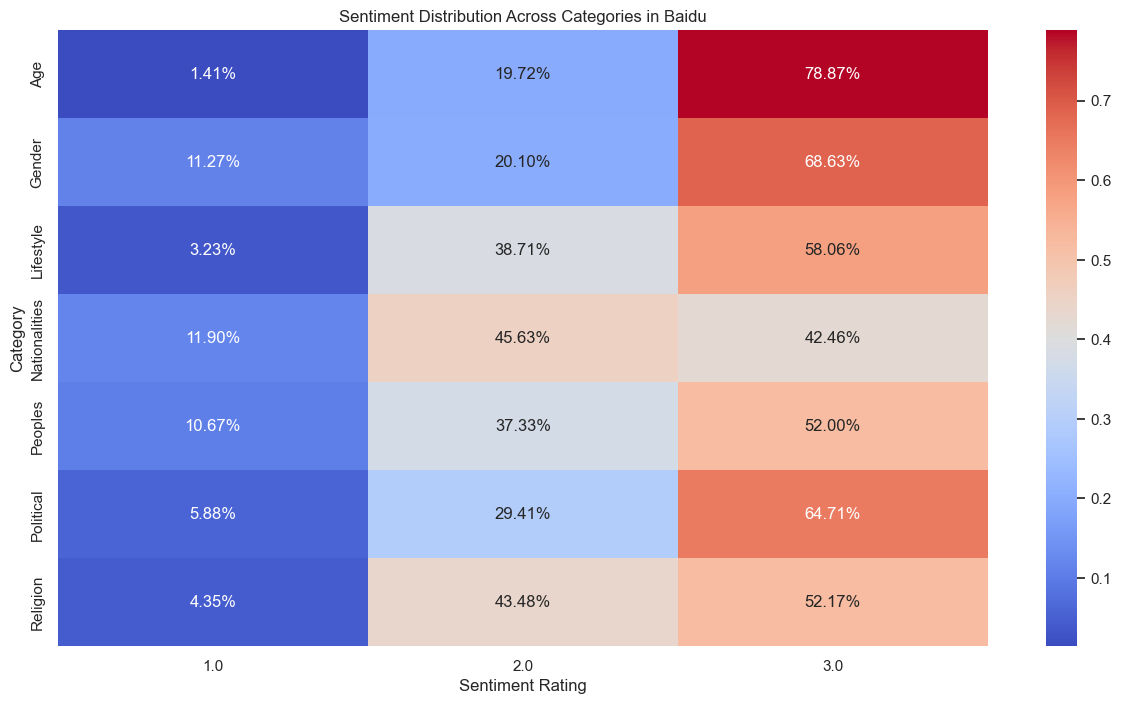

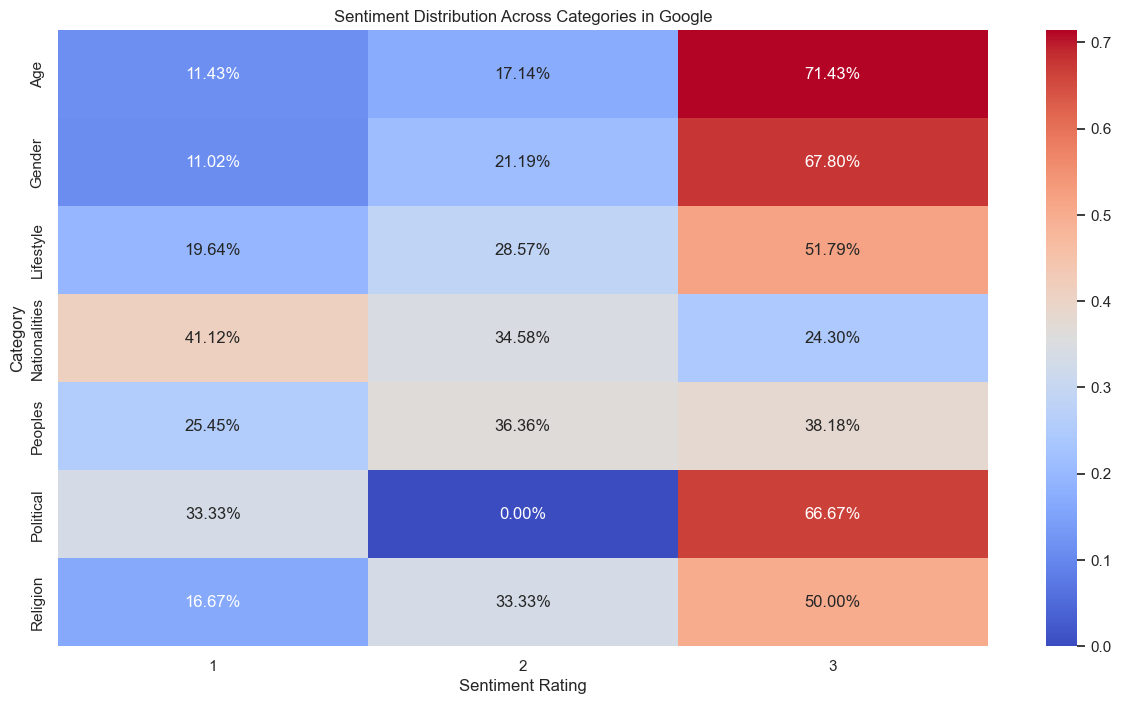

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'baidu' and 'google' DataFrames are already loaded and preprocessed

# Function to analyze sentiment distribution and return proportions
def analyze_sentiment_distribution(df, category_col, sentiment_col):
    # Group by category and sentiment rating
    sentiment_distribution = df.groupby([category_col, sentiment_col]).size().unstack(fill_value=0)

    # Calculate proportions
    sentiment_proportions = sentiment_distribution.div(sentiment_distribution.sum(axis=1), axis=0)

    return sentiment_proportions

# Analyze sentiment distribution for Baidu
baidu_sentiment_proportions = analyze_sentiment_distribution(baidu, 'category', 'common_sentiment_rating')

# Analyze sentiment distribution for Google
google_sentiment_proportions = analyze_sentiment_distribution(google, 'category', 'common_sentiment_rating')

# Plotting the distribution for Baidu
plt.figure(figsize=(15, 8))
sns.heatmap(baidu_sentiment_proportions, annot=True, fmt=".2%", cmap='coolwarm')
plt.title('Sentiment Distribution Across Categories in Baidu')
plt.ylabel('Category')
plt.xlabel('Sentiment Rating')
plt.show()

# Plotting the distribution for Google
plt.figure(figsize=(15, 8))
sns.heatmap(google_sentiment_proportions, annot=True, fmt=".2%", cmap='coolwarm')
plt.title('Sentiment Distribution Across Categories in Google')
plt.ylabel('Category')
plt.xlabel('Sentiment Rating')
plt.show()


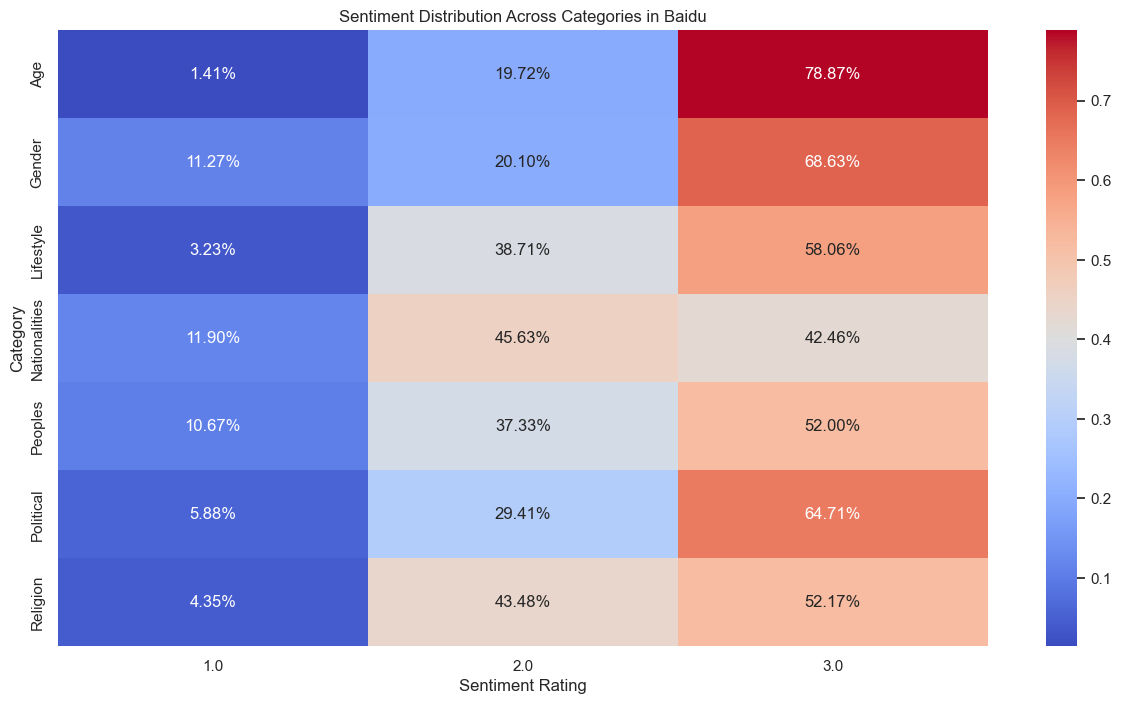

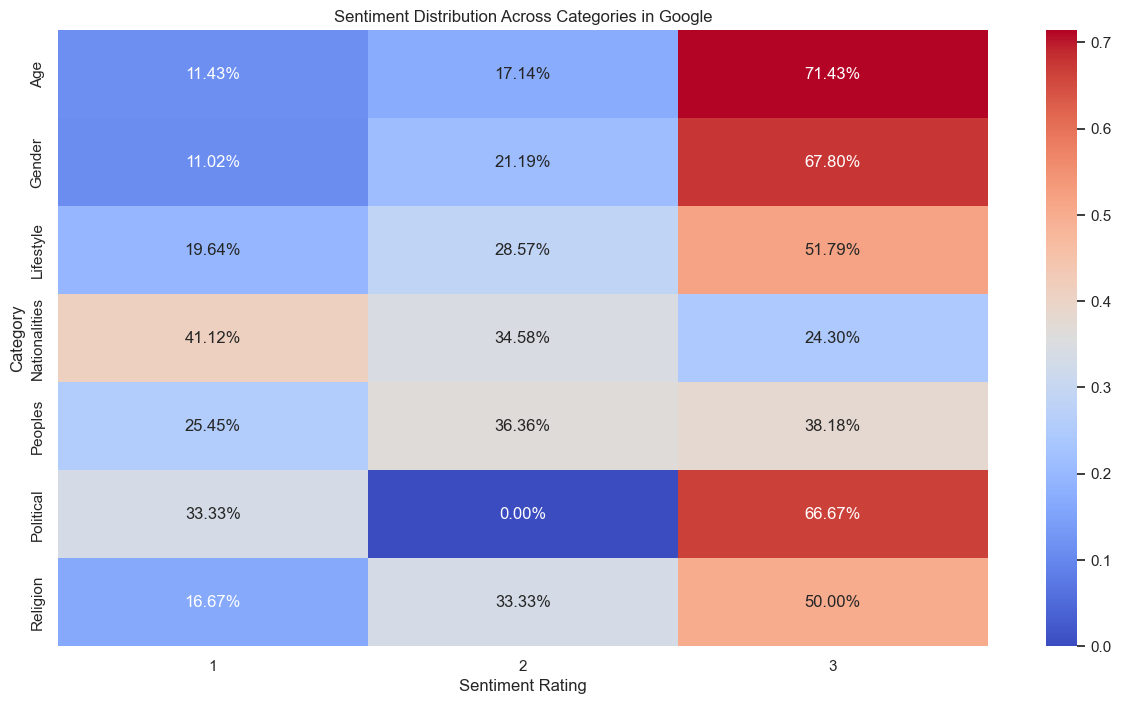

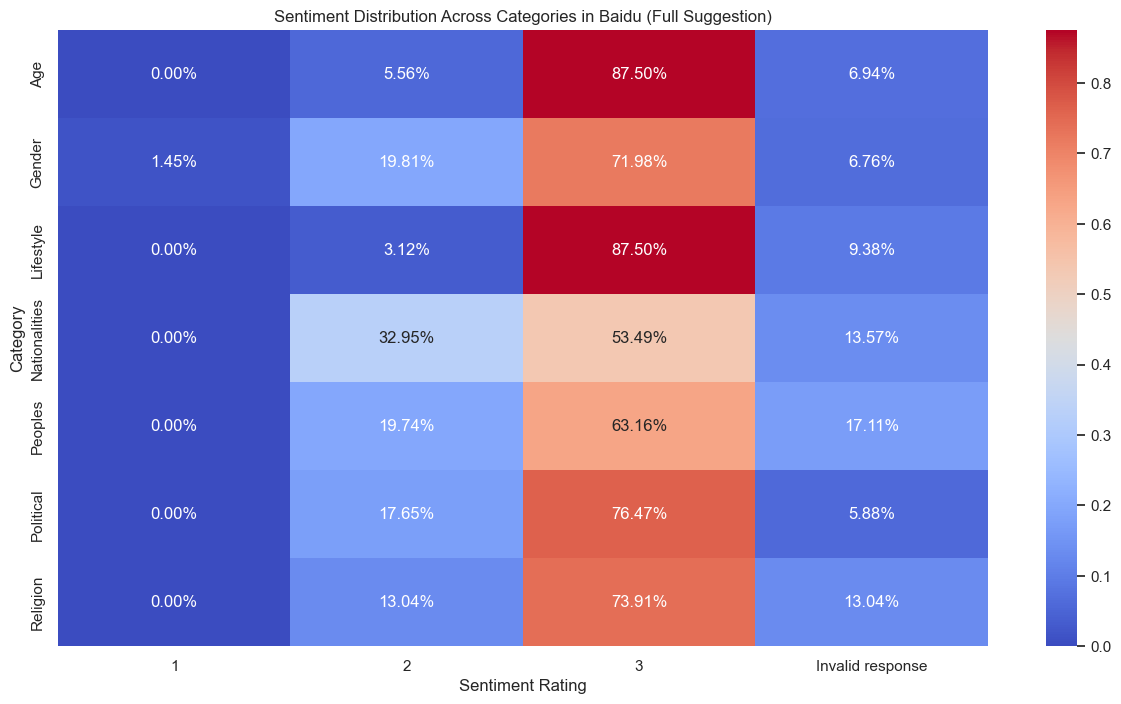

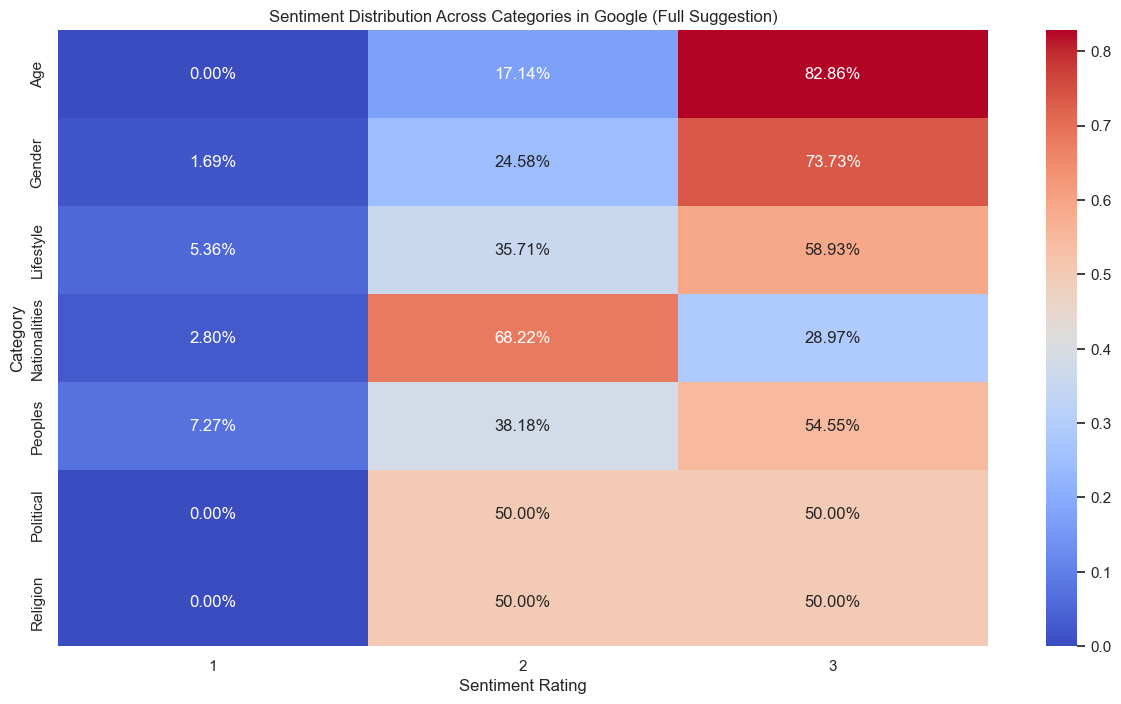

In [23]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'baidu' and 'google' DataFrames are already loaded and preprocessed

# Function to analyze sentiment distribution and return proportions
def analyze_sentiment_distribution(df, category_col, sentiment_col):
    # Group by category and sentiment rating
    sentiment_distribution = df.groupby([category_col, sentiment_col]).size().unstack(fill_value=0)

    # Calculate proportions
    sentiment_proportions = sentiment_distribution.div(sentiment_distribution.sum(axis=1), axis=0)

    return sentiment_proportions

# Analyze sentiment distribution for Baidu
baidu_sentiment_proportions = analyze_sentiment_distribution(baidu, 'category', 'common_sentiment_rating')

# Analyze sentiment distribution for Google
google_sentiment_proportions = analyze_sentiment_distribution(google, 'category', 'common_sentiment_rating')

# Plotting the distribution for Baidu
plt.figure(figsize=(15, 8))
sns.heatmap(baidu_sentiment_proportions, annot=True, fmt=".2%", cmap='coolwarm')
plt.title('Sentiment Distribution Across Categories in Baidu')
plt.ylabel('Category')
plt.xlabel('Sentiment Rating')
plt.show()

# Plotting the distribution for Google
plt.figure(figsize=(15, 8))
sns.heatmap(google_sentiment_proportions, annot=True, fmt=".2%", cmap='coolwarm')
plt.title('Sentiment Distribution Across Categories in Google')
plt.ylabel('Category')
plt.xlabel('Sentiment Rating')
plt.show()






import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to analyze sentiment distribution and return proportions
def analyze_sentiment_distribution_full_suggestion(df, category_col, sentiment_col):
    # Group by category and sentiment rating
    sentiment_distribution = df.groupby([category_col, sentiment_col]).size().unstack(fill_value=0)

    # Calculate proportions
    sentiment_proportions = sentiment_distribution.div(sentiment_distribution.sum(axis=1), axis=0)

    return sentiment_proportions

# Analyze sentiment distribution for Baidu for full suggestion
baidu_sentiment_proportions_full = analyze_sentiment_distribution_full_suggestion(baidu, 'category', 'sentiment_rating_full_suggestion')

# Analyze sentiment distribution for Google for full suggestion
google_sentiment_proportions_full = analyze_sentiment_distribution_full_suggestion(google, 'category', 'sentiment_rating_full_suggestion')

# Plotting the distribution for Baidu for full suggestion
plt.figure(figsize=(15, 8))
sns.heatmap(baidu_sentiment_proportions_full, annot=True, fmt=".2%", cmap='coolwarm')
plt.title('Sentiment Distribution Across Categories in Baidu (Full Suggestion)')
plt.ylabel('Category')
plt.xlabel('Sentiment Rating')
plt.show()

# Plotting the distribution for Google for full suggestion
plt.figure(figsize=(15, 8))
sns.heatmap(google_sentiment_proportions_full, annot=True, fmt=".2%", cmap='coolwarm')
plt.title('Sentiment Distribution Across Categories in Google (Full Suggestion)')
plt.ylabel('Category')
plt.xlabel('Sentiment Rating')
plt.show()
